# Kaggle histopathology introduction
This notebook is an introduction to the data challenge of out of distribution classification of histopathology patches. It also serves as a baseline for the code and the model.

If you have any questions, feel free to contact me at [leo.fillioux@centralesupelec.fr](mailto:leo.fillioux@centralesupelec.fr).

In [7]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [8]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0

In [3]:
torch.random.manual_seed(SEED)
random.seed(SEED)

## 1. Introduction to the data
The dataset consists of patches of whole slide images which should be classified into either containing tumor or not. The training images come from 3 different centers (i.e. hospitals), while the validation set comes from another center and the test set from yet another center. The visual aspect of the patches are quite different due to the slightly different staining procedures, conditions, and equipment from each hospital. The objective of the task is to build a classifier that is impacted by this distribution shift as little as possible.

The data is stored in `.h5` files, which can be seen as a folder hierarchy, which are can be seen as the following.
```
├── idx           # index of the image
│   └── img       # image in a tensor format
│   └── label     # binary label of the image
│   └── metadata  # some metadata on the images
```
The metadata is included for completeness but is not necessarily useful. The first element in the metadata corresponds to the center.

The following is a visualization of how different the images look from the different centers.

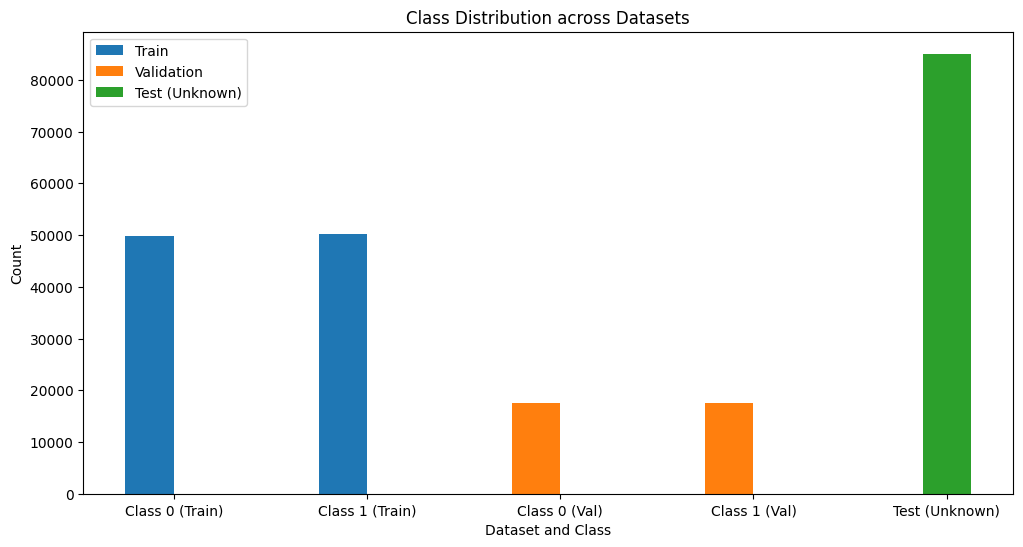

In [16]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_histograms(train_path, val_path, test_path):
    # Initialize class counts for each dataset
    class_counts_train = {0: 0, 1: 0}
    class_counts_val = {0: 0, 1: 0}
    test_count = 0  # No class labels for test data
    
    # Count classes for the training dataset
    with h5py.File(train_path, 'r') as hdf:
        for img_idx in hdf.keys():
            label = int(np.array(hdf.get(img_idx).get('label')))
            class_counts_train[label] += 1
    
    # Count classes for the validation dataset
    with h5py.File(val_path, 'r') as hdf:
        for img_idx in hdf.keys():
            label = int(np.array(hdf.get(img_idx).get('label')))
            class_counts_val[label] += 1
    
    # Count the number of test samples (no labels)
    with h5py.File(test_path, 'r') as hdf:
        test_count = len(hdf.keys())  # Number of samples in the test set
    
    # Plot all histograms on the same plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Bar width for the different datasets
    bar_width = 0.25
    
    # X positions for each dataset's bars
    train_pos = np.array([0, 1])
    val_pos = np.array([2, 3])
    test_pos = np.array([4])  # Single bar for the test dataset
    
    # Plotting the histograms for each dataset
    ax.bar(train_pos - bar_width / 2, class_counts_train.values(), bar_width, label='Train', tick_label=['Class 0', 'Class 1'])
    ax.bar(val_pos - bar_width / 2, class_counts_val.values(), bar_width, label='Validation')
    ax.bar(test_pos, [test_count], bar_width, label='Test (Unknown)')
    
    # Set the labels and title
    ax.set_title('Class Distribution across Datasets')
    ax.set_xlabel('Dataset and Class')
    ax.set_ylabel('Count')
    
    # Adjust x-ticks to be at the correct positions
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Class 0 (Train)', 'Class 1 (Train)', 'Class 0 (Val)', 'Class 1 (Val)', 'Test (Unknown)'])
    
    # Add a legend
    ax.legend()
    
    plt.show()

# Example usage:
plot_combined_histograms(TRAIN_IMAGES_PATH, VAL_IMAGES_PATH, TEST_IMAGES_PATH)

In [ ]:
def count_centers_in_dataset(path):
    center_counts = {}
    with h5py.File(path, 'r') as hdf:
        for img_idx in hdf.keys():
            metadata = hdf.get(img_idx).get('metadata')
            metadata_array = np.array(metadata)
            
            # print(f"Image {img_idx} metadata shape: {metadata_array.shape}")
            if metadata_array.ndim > 0:
                center = int(metadata_array[0])
            else:
                # Handle case where the metadata is not as expected
                print(f"Unexpected metadata format for image {img_idx}. Skipping.")
                continue
            
            center_counts[center] = center_counts.get(center, 0) + 1
    return center_counts

train_center_counts = count_centers_in_dataset(TRAIN_IMAGES_PATH)
val_center_counts = count_centers_in_dataset(VAL_IMAGES_PATH)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Training dataset histogram
axs[0].bar(train_center_counts.keys(), train_center_counts.values(), color='blue')
axs[0].set_title('Train Dataset - Center Repartition')
axs[0].set_xlabel('Center')
axs[0].set_ylabel('Count')

# Validation dataset histogram
axs[1].bar(val_center_counts.keys(), val_center_counts.values(), color='green')
axs[1].set_title('Validation Dataset - Center Repartition')
axs[1].set_xlabel('Center')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()